# Predicting Stroke using Machine Learning

## 1. Problem Definition

We are going to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status

Here is the dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## 2. Features

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

### Preparing the tools

In [39]:
# Regular EDA and plotting libraries
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns

# We want our plots to appear in the notebook
%matplotlib inline 

## Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve # note: this was changed in Scikit-Learn 1.2+ to be "RocCurveDisplay" (see below)
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Wed Sep 13 19:42:51 2023


### Load data

In [2]:
df = pd.read_csv("../raw_data/healthcare-dataset-stroke-data.csv") # 'DataFrame' shortened to 'df'
df.shape # (rows, columns)

(5110, 12)

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

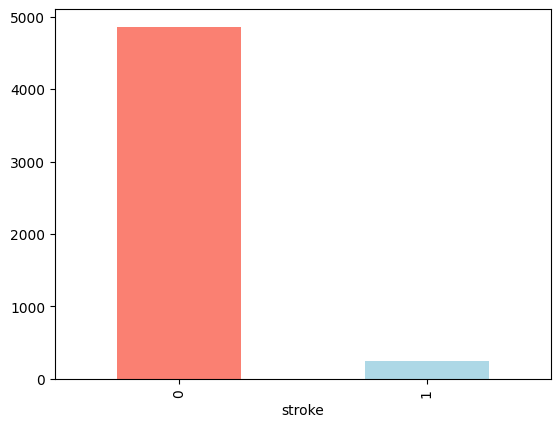

In [5]:
# Plot the value counts with a bar graph
df.stroke.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

We can see that the values are not well balanced. We must do something.

**TODO: Balance the targe**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Make ids as the indexs of the Dataframe

In [3]:
df.set_index('id', inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3. Modeling

### Create X and y

In [4]:
# Everything except target variable
X = df.drop("stroke", axis=1)

# Target variable
y = df.stroke

In [10]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [11]:
y.head()

id
9046     1
51676    1
31112    1
60182    1
1665     1
Name: stroke, dtype: int64

### Check for missing data

In [6]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We see that bmi is the only feature with missing values. Let's fix that

In [7]:
target = 'stroke'
target

'stroke'

In [8]:
features = np.array(list(filter(lambda x: x != target, df.columns)))
features

array(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'], dtype='<U17')

In [16]:
# Fill categorical numerical with mean
bmi_imputer = SimpleImputer(strategy="mean")

In [32]:
features_without_bmi = list(filter(lambda x: x != 'bmi' and x != target, df.columns))
features_without_bmi

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'smoking_status']

In [33]:
features_reordered = np.array(['bmi'] + features_without_bmi)
features_reordered

array(['bmi', 'gender', 'age', 'hypertension', 'heart_disease',
       'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level',
       'smoking_status'], dtype='<U17')

In [34]:
len(features_reordered)

10

In [66]:
imputer = ColumnTransformer(
    transformers = [("bmi_imputer", bmi_imputer, ["bmi"])],
    # set remainder to passthrough to pass along all the un-specified columns untouched to the next steps
    remainder='passthrough'
)

# Fill train and test values separately
filled_X_raw= imputer.fit_transform(X)

In [67]:
filled_X_raw

array([[36.6, 'Male', 67.0, ..., 'Urban', 228.69, 'formerly smoked'],
       [28.893236911794666, 'Female', 61.0, ..., 'Rural', 202.21,
        'never smoked'],
       [32.5, 'Male', 80.0, ..., 'Rural', 105.92, 'never smoked'],
       ...,
       [30.6, 'Female', 35.0, ..., 'Rural', 82.99, 'never smoked'],
       [25.6, 'Male', 51.0, ..., 'Rural', 166.29, 'formerly smoked'],
       [26.2, 'Female', 44.0, ..., 'Urban', 85.28, 'Unknown']],
      dtype=object)

In [69]:
# Get our transformed data array's back into DataFrame's
filled_X = pd.DataFrame(filled_X_raw, columns=features_reordered )

# Check missing data in training set
filled_X.isna().sum()

bmi                  0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
smoking_status       0
dtype: int64

In [71]:
filled_X.shape

(5110, 10)

### Encode features

In [73]:
filled_X.head()

,bmi,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status
0,36.6,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked
1,28.893237,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked
2,32.5,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked
3,34.4,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes
4,24.0,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked


In [85]:
# Now let's one hot encode the features with the same code as before 
categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", 
                                 one_hot, 
                                 categorical_features)],
                                 remainder="passthrough")

# # Fill train and test values separately
transformed_X = transformer.fit_transform(filled_X)

# # Check transformed and filled X_train
transformed_X

array([[0.0, 1.0, 0.0, ..., 36.6, 67.0, 228.69],
       [1.0, 0.0, 0.0, ..., 28.893236911794666, 61.0, 202.21],
       [0.0, 1.0, 0.0, ..., 32.5, 80.0, 105.92],
       ...,
       [1.0, 0.0, 0.0, ..., 30.6, 35.0, 82.99],
       [0.0, 1.0, 0.0, ..., 25.6, 51.0, 166.29],
       [1.0, 0.0, 0.0, ..., 26.2, 44.0, 85.28]], dtype=object)

**We don't put labels on the columns as the model does not need it**

### Create model

In [76]:
y_train.head()

id
4970     0
56137    0
54590    0
36548    0
61171    0
Name: stroke, dtype: int64

### Split the data

In [83]:
# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(transformed_X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

In [84]:
# Now we've transformed X, let's see if we can fit a model
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# Make sure to use transformed (filled and one-hot encoded X data)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9393346379647749